# Scale growth and isotope diffusion - version 8.1

In [10]:
version  = '8.1'

##### This code was written to solve a fully one-dimensionsal version of the Mishin and Borchardt (MB) equations. Starting with version 7 it is  becoming a 2D version, to include diffusion into the grains from the grain boundaries.
Their variable $c'$ is the excess concentration of an isotope (we assume $^{18}$O) on the grain boundary (GB)
perpendicular to the interfaces.
In this code  $c'$ is called c_GB.

Not yet done: Replace the simple bleeding model by proper finite-difference diffusion into the bulk (x-direction)\


Changes to version 8.0:\
Introduce c_GB_temp to consistently label the new values as they are updated at each timestep\
Add a file for text output to the output folder for figures

Changes to version 7.2:\
More tidyng up and testing, bug fixes.\
Include exit with ValueError if the initial timestep is too big (Inflation factor >= 1.0).

Changes to versions 7 and 7.1:\
Minor bug fixes to enable new runs without killing kernel between runs.\
Eliminate all use of global variables in favour of arguments to functions.\
Graphs for each run are now saved to a new folder named by the date and time.

Changes to version 6: \
Bug fixes to plotting routine\
Save plots to a file with date and time\
Updated plotting function and calling routing to save a specified array of figures to a page. \
Updated documentation cell.

Changes to version 5:\
Introduce some bleeding of the isotope into the bulk (x-direction)\
Update plotting function to save numbered figures to pdfs.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime


Diagram.png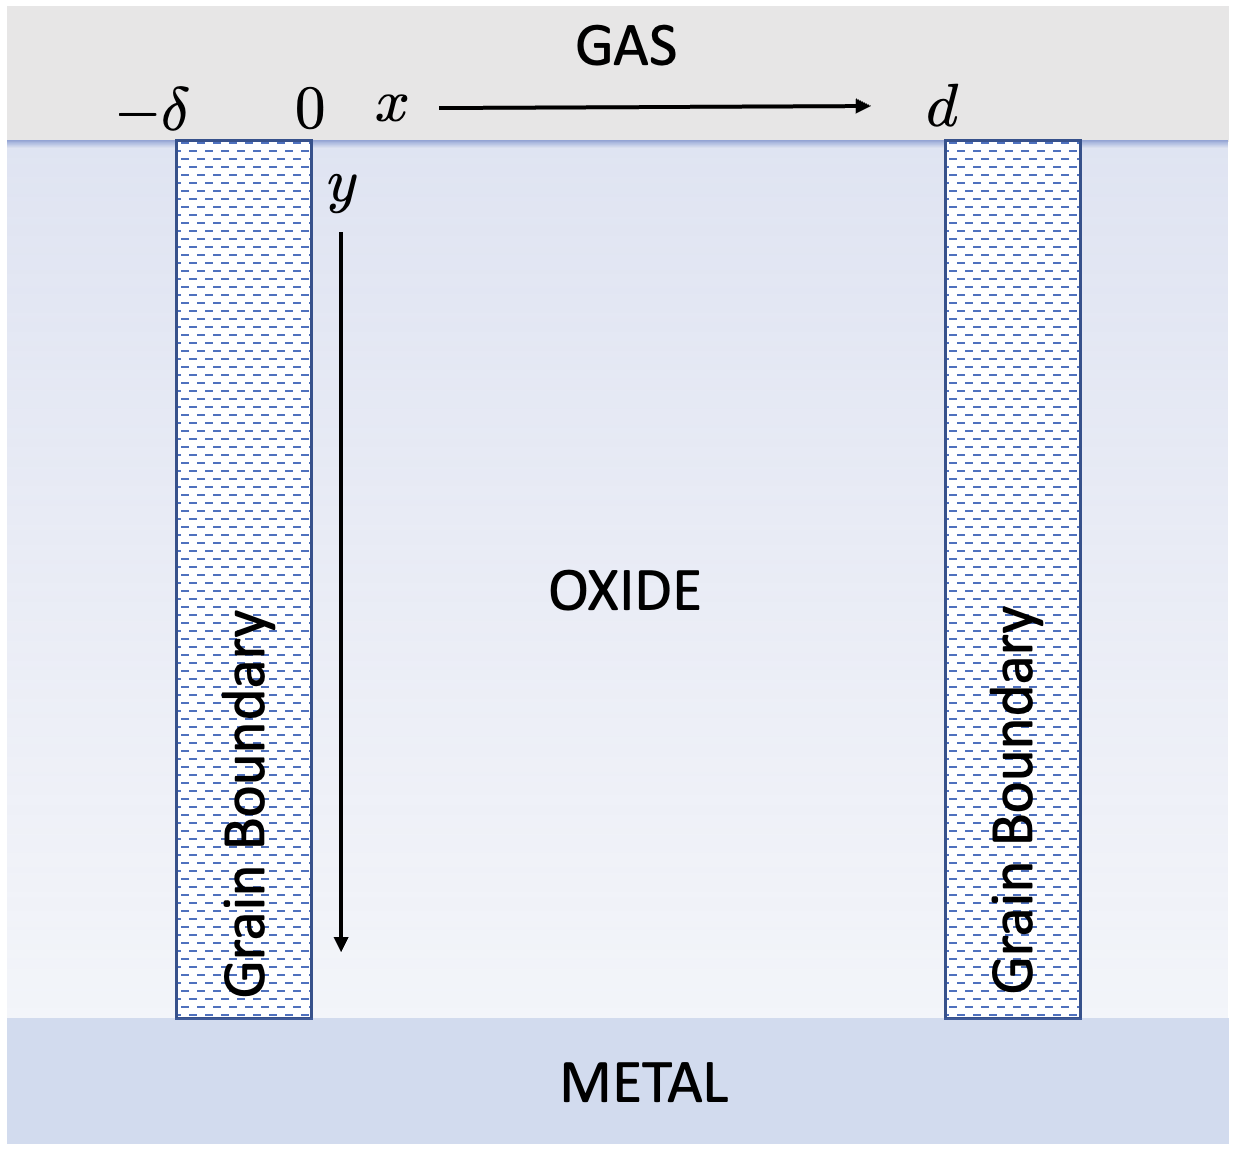


Simplest approach first. The 1-D equation with only oxygen transport, and only on GB, looks like (MB-I,17}
$$
\frac{\partial c'}{\partial t} = \frac{\partial}{\partial y}\left(D'\frac{\partial c'}{\partial y}\right)
-V'\frac{\partial c'}{\partial y}
$$
where
$$
V' = \frac{J'_{\text{O}}}{c_{\text{O}}} = \frac{1}{kTL}\int_{\mu_L}^{\mu_0}D_{\text{O}}' \text{d}\mu
$$
and
$$
D' = f'D_{\text{O}}'
$$
and 
$$
f' = (1-c'_{\text{O}}/c'_{\text{O}p})
$$
Maintaining the fiction that GB transport is by vacancy hopping, $f'$ is the fractional occupation of oxygen sites by vacancies, thus $c_{\text{O}p}$ is the density of oxygen in the perfectly stoichiometric boundary.

If we assume zero divergence of the flux,  $D'_{\text{O}} = constant$ and $\mu = kT\ln c_{\text{O}}'$ we can write the flux above as
$$
J'_{\text{O}} = D_{\text{O}}'(c_{\text{O}}'(0) - c_{\text{O}}'(L))/L.
$$
In terms of the fractional occupancy of oxygen sites by vacancies (effectively zero at the scale surface) this can be expressed as
$$
J'_{\text{O}} = D_{\text{O}}' \frac{3 f'(L)}{\Omega L}.
$$
NOTE: This is a bad notation because $f'(L)$ is constant, the value at the scale-metal boundary, even as $L$ increases with $t$. 

Boundary conditions:

$$c'(0,t) = 1.0$$
$$\frac {\partial c'(y=1,t)}{\partial y} = 0$$
$$f'(0) = 0$$
$$f'(L) = parameter$$
where $f'(L)$ will be set to a small oxygen vacancy site occupancy at the scale-metal interface. 
We can assume there are practically no vacancies on the outside of the scale compared to the oxide-metal interface. 

In order to scale the length with time, we need the velocities of the interfaces. With only oxygen diffusion considered, the velocity $V'$ given above is all we need. MB defined the velocity of the oxide-metal interfac (MB-I-6) as:
$$
V_2 =[\nu j_{\text{O}}'+(1-\nu)j_{\text{O}}]/c_{\text{O}},
$$
where $\nu$ is the fraction of the width in the $x$-direction occupied by grain boundary, and the two fluxes refer to grain boundary and bulk respectively. $c_{\text{O}}$ stands for the concentration of oxygen atoms per unit volume. I have used a different notation here, and start by ignoring the bulk transport altogether, so in the notation of the code $j_{\text{O}}' \to$ j_O_GB. A similar equation applies to the gas-scale interface with O replaced by Al. Our rest frame of reference is the alumina lattice, on which the majority of ions at any instant are vibrating but not contributing to the fluxes. We are simulating on a grid (a numpy array) of fixed nodes separated by dy, so we need to discover how many timesteps, delta_n_t, each of size d$t$, are needed for the scale to advance by dy, at which point we have to extend by one node the segment of nodes that define the scale within the fixed array, occupied by alumina, by one element. The velocity of the interface will be 
$$
\text{V}_2 = \frac{\text{dl}}{\text{delta_n_t}\,\text{dt}}
$$
so
$$
\text{delta_n_t} = \frac{\text{d}l}{\text{d}t}\frac{c_{\text{O}}}{ \nu j_{\text{O}}'} 
= \frac{\text{d}l}{\text{d}t}\frac{3}{ \nu j_{\text{O}}'\Omega} 
= \frac{\text{d}l}{\text{d}t}\frac{L}{ \nu D'_{\text{O}}f'(L)} 
$$
where $\Omega$ is the volume of an Al$_2$O$_3$ molecular unit in the scale, neglecting the small concentration of defects.  Within this simple model we can can also express $V_2$ as
$$
V_2 = \frac{\nu D'_{\text{O}}f'(L)}{L(t)}
$$
The reference position for velocities here is the location of the oxygen lattice, which is the location of the original slab of oxide scale. So $V_2$ is positive, because the metal substrate is moving to the right!
In a similar way, with respect to the oxygen lattice, the position of the scale gas interface is moving to the left, so its velocity $V_1$ is negative, given by:
$$
V_1 = -\frac{\nu D'_{\text{Al}}f'(\text{Al})}{L(t)},
$$
where $f'(\text{Al})$ will be set to the Al vacancy concentration at the scale-gas boundary, and like $f'(L)$ it is a constant, independent of $L$.  \
The parabolic growth law follows from the rate of change of $L$:
$$
\frac{\text{d}L}{\text{d}t} = V_2-V_1 =  \frac{\nu (D'_{\text{O}}f'(L)+ D'_{\text{Al}}f'(\text{Al}))}{L(t)}.
$$
So if we start the clock at time $t=0$ when the scale thickness is $L_0$ we have
$$
L(t) = \sqrt{ L_0^2 +\
2\nu t[D'_{\text{O}}f'(L)+ D'_{\text{Al}}f'(\text{Al})]}
$$

INTERPRETATION OF EXPERIMENTS

If we can measure separately the thickness of new scale formed at the metal  and at the gas interfaces, 
call it $l_2$ and $l_1$ respectively, where
$$
L(t) = L_0 + l_1(t) + l_2(t),
$$
it is easy to show that this simple model makes the prediction:
$$
\frac{l_2(t)}{l_1(t)} = \frac{D'_{\text{O}}f'(L)}{D'_{\text{Al}}f'(\text{Al})}.
$$
Thus the ratio of thicknesses of the new scale is independent of time. 
These equations might enable us to extract the products $\nu (D'_{\text{O}}f'(L)$ and $D'_{\text{Al}}f'(\text{Al}))$ from experimental data, but the factors $\nu$ and the "vacancy concentrations" $f'(L)$ and $f'(\text{Al})$ would remain undetermined. Perhaps by inserting reasonable values of these parameters the unreasonableness of the simple model could be established, and alternative transport mechanisms considered. 

DIMENSIONLESS UNITS

It is very convenient, for generality of interpretation as well as for coding, to work with dimensionless variables, such that:

Unit of length will be initial thickness of the scale, $L(0)$ referred to in the code as length_0

Unit of time will be $L(0)^2/D'_{\text{O}}$ referred to in the code as length_0^2/mobility_Ox_GB

In these dimensionless units, $V_2$ and delta_n_t are simply
$$
V_2 = \nu f'(L(0))/L
$$
referred to in the code as $\text{v_2 = nu*f_Ox_GB}$ initially, and this decreases by a faxtor $L(0)/L(t)$ as the thickness of the scale increases.
We expect the scale to grab a node from the metal after a number of time given roughly by
$$ 
\text{delta_n_t} = dl/V_2 
$$

EXTENSION TO 2 DIMENSIONS - into x-direction

Good news: If we retain the vacancy model, in the quasi-steady state we can still have linear concentrations of vacancies versus y. In both GB and bulk the gradients are along x, and there is a constant ratio between the bulk and GB values. This is a perfectly good solution to Laplace's equation with the boundary condition that the vacancy concentration on a grain boundary at x is in equilibrium with the vacancy concentration at the adjacent bulk x-value.

In [12]:
"""
Initialize all the variables that should not be changed in the rest of the code

"""
# Initial scale thickness, the length scale for dimensionless equations, should be 1.0.
# so not necessarily referenced in code.
length_0 = 1.0
# Oxygen diffusion coeffient $D_{\text{O}'$ on the grain boundary as defined by MB
# Should always be 1.0 for dimensionless equations, so not necessarily referenced in code.
mobility_Ox_GB = 1.0
# Aluminium diffusion coeffient $D_{\text{Al}'$ on the grain boundary as defined by MB
# represented here as its ratio to $D_{\text{O}'$.
mobility_Al_GB = 1.0
# We define bulk diffusion coefficients in a similar way:
mobility_Ox_bulk = 0.01
mobility_Al_bulk = 0.01
# Initialize the number of nodes of each type on the grid along the y-axis
# Number of nodes for growth into gas phase
ngridy_gas_0 = 20
# Number of nodes covering initial scale
ngridy_scale_0 = 51
# Number of nodes for growth into metal phase
ngridy_metal_0 = 20
# Fixed total provision of nodes for  gas-scale-metal. This will not be changed in the code.
ngridy_max = ngridy_scale_0 + ngridy_gas_0 + ngridy_metal_0
# Ratio nu of thickness of grain boundary delta to (delta + d)
nu = 0.1
# f' as defined by MB, or the oxygen vacancy concentration at the oxide-metal interface
f_Ox_GB = 0.0001
# We define here the notionally similar quantity for Al, which would be the Al vacancy
# concentration at the gas-scale interface. This is only used to scale the velocity of the
# gas-scale interface
f_Al_GB = 0.0001
# We shall also need the corresponding concentrations for the bulk grains:
f_Ox_bulk = 0.0001
f_Al_bulk = 0.0001
# Initial velocity of scale-metal interface (> 0)
# Note - velocities are measured with respect to the fixed lattice of the scale.
# So we imagine that as the scale grows it pushes the interfaces back in opposite directions.
v_2_0 = nu*f_Ox_GB
# Initial velocity of gas-scale interface (< 0)
v_1_0 = - nu*f_Al_GB*mobility_Al_GB
# Distances along the y-axis for the fixed array of nodes to cover the three phases
# The origin (y = 0) is chosen to be the first node of the initial scale, 
# and y=1 is the initial position of the last node of the scale.
# These distances are set up here and should not be changed by the subsequent code. 
gridy_max = (np.linspace(0,ngridy_max-1,ngridy_max)-ngridy_gas_0)/(ngridy_scale_0-1)
# Increment of distances, a constant
dy = gridy_max[1]-gridy_max[0]
# Initial excess oxygen isotope.
# The gas is treated as having an isotope fraction of 1.
c_GB_0 = np.zeros_like(gridy_max)
c_GB_0[0:ngridy_gas_0+1] = 1.0
np.set_printoptions(precision=6)
# print('gridy_max =\n',np.array2string(gridy_max))
print('gridy_max = \n',gridy_max)
print('\nc_GB_0 = \n',c_GB_0)
# Initial oxygen vacancy concentration
vac_Ox_0 = np.zeros_like(gridy_max)
for ny in range(ngridy_gas_0+1,ngridy_gas_0+ngridy_scale_0):
    vac_Ox_0[ny] =  f_Ox_GB*(gridy_max[ny]-gridy_max[ngridy_gas_0])
print('\nOxygen vacancy concentration (vacancies per O-lattice site):\n',vac_Ox_0)
# Set up bulk nodes. 
# Number in y-direction is same as GB, numbe in x-direction:
ngrid_x = 5
# The first bulk node will have the same concentration as the GB,
# The last bulk node is on the mid-line of the scale, which is a mirror plane.

gridy_max = 
 [-0.4  -0.38 -0.36 -0.34 -0.32 -0.3  -0.28 -0.26 -0.24 -0.22 -0.2  -0.18
 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06
  0.08  0.1   0.12  0.14  0.16  0.18  0.2   0.22  0.24  0.26  0.28  0.3
  0.32  0.34  0.36  0.38  0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54
  0.56  0.58  0.6   0.62  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78
  0.8   0.82  0.84  0.86  0.88  0.9   0.92  0.94  0.96  0.98  1.    1.02
  1.04  1.06  1.08  1.1   1.12  1.14  1.16  1.18  1.2   1.22  1.24  1.26
  1.28  1.3   1.32  1.34  1.36  1.38  1.4 ]

c_GB_0 = 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Oxygen vacancy concentration (vacancies per O-lattice site):
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+

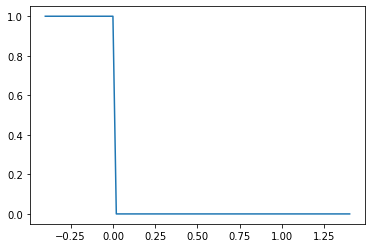

In [13]:
fig = plt.figure()
"""
The initial fraction of isotope

"""
ax = fig.add_subplot()
line_c_GB_0 = ax.plot(gridy_max, c_GB_0)
plt.show()

In [14]:
    
""" 
DEFINE TRACER  DIFFUSION COEFFICIENT AND ITS DERIVATIVE

"""
# Oxygen tracer diffusion coefficient d_GB and its linear y-derivative dd_GB
d_GB_0 = np.zeros_like(gridy_max)
dd_GB_0 = np.zeros_like(gridy_max)
for ny in range(ngridy_gas_0+1,ngridy_gas_0+ngridy_scale_0):   
    d_GB_0[ny] = vac_Ox_0[ny]
    dd_GB_0[ny] = (vac_Ox_0[ny+1]-vac_Ox_0[ny-1])/(2.0*dy)
# Correct the last value of this gradient, else it would be negative and nonsense.     
dd_GB_0[ngridy_gas_0+ngridy_scale_0-1] = dd_GB_0[ngridy_gas_0+ngridy_scale_0-2]
print('\nTracer diffusion coefficient:\n',d_GB_0)
print('\ny-derivative of tracer diffusion coefficient:\n',dd_GB_0)


Tracer diffusion coefficient:
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 2.0e-06 4.0e-06 6.0e-06 8.0e-06 1.0e-05 1.2e-05
 1.4e-05 1.6e-05 1.8e-05 2.0e-05 2.2e-05 2.4e-05 2.6e-05 2.8e-05 3.0e-05
 3.2e-05 3.4e-05 3.6e-05 3.8e-05 4.0e-05 4.2e-05 4.4e-05 4.6e-05 4.8e-05
 5.0e-05 5.2e-05 5.4e-05 5.6e-05 5.8e-05 6.0e-05 6.2e-05 6.4e-05 6.6e-05
 6.8e-05 7.0e-05 7.2e-05 7.4e-05 7.6e-05 7.8e-05 8.0e-05 8.2e-05 8.4e-05
 8.6e-05 8.8e-05 9.0e-05 9.2e-05 9.4e-05 9.6e-05 9.8e-05 1.0e-04 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00]

y-derivative of tracer diffusion coefficient:
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 1.e-04 1.e-04 1.e-04 1.e-04 1.

In [15]:
def plot_concentrations(new_page, plot_count,fig_number, first_or_second, \
                        graph_layout,number_plots,\
                        title = 'Scale growth',c_1=c_GB_0, c_2=c_GB_0, \
                        label_1 = 'c_1', label_2='c_2'):
    """
    new_page : if zero, open a new page to plot figures on, if   
    graph-layout : tuple to specify the layout of figures on a page, e.g. (2,3).
    first_or_second : if set to 1, plot just one figure, c_1
                      if set to 2 plot only second figure,  c_2
                      if set to anything else, plot both graphs
    """
    print('\n*** ENTERING plot_concentrations ***\n')
    nfigsx, nfigsy = graph_layout
    max_figs_per_page = nfigsx*nfigsy
    # Count the number of figures so far on the current page
    figs_on_page = plot_count%max_figs_per_page
    print('plot_count = ',plot_count, " figs_on_page = ", figs_on_page," max_figs_per_page = ", max_figs_per_page)
    if figs_on_page == 0:
        new_page = plt.figure(figsize =(6,8))
    ax = new_page.add_subplot(nfigsx,nfigsy,figs_on_page+1)
    if first_or_second == 1:
        line_c_1 = ax.plot(gridy_max, c_1,label=label_1)
    elif first_or_second == 2:
        line_c_2 = ax.plot(gridy_max, c_2,label=label_2)
    else:
        line_c_1 = ax.plot(gridy_max, c_1,label=label_1)
        line_c_2 = ax.plot(gridy_max, c_2,label=label_2)
    plt.legend(loc="lower left")
    plt.xlabel('Depth into scale', fontdict=None, labelpad=None        )
    plt.ylabel('Fraction of isotope', fontdict=None, labelpad=None    )
    plt.title(title)
    plot_count += 1
    figs_on_page +=1
    if number_plots == plot_count:
        new_page.tight_layout()
        plt.savefig('Figure_{}.pdf'.format(plot_count))
        plt.show()
        plt.close()
    elif figs_on_page == max_figs_per_page:
        new_page.tight_layout()
        plt.savefig('Figure_{}.pdf'.format(plot_count))
        plt.show()
        plt.close()
    print('\nplot_count =',plot_count, " figs_on_page =", figs_on_page," max_figs_per_page =", max_figs_per_page)
    print('\n*** LEAVING plot_concentrations ***\n')
    return new_page, plot_count

In [16]:
def update_ranges(direction, ngridy_gas, ngridy_scale, ngridy_metal,c_GB,vac_Ox,d_GB,dd_GB):
    """
    Increment the numbers of nodes in each region, ngridy_gas, ngridy_scale, ngridy_metal,
    according to the direction of scale growth. 
    The overall number of nodes remains fixed. Possible parameter values:
    direction = +1 : The scale grows by 1 node while the metal retreats by 1 node           
    direction = -1: The scale grows by 1 node while the gas retreats by 1 node 
    Then update the other parameters, c_GB, vac_Ox, d_GB, dd_GB, because they depend on the new length 
    of the scale.
    
    """
    print('\n*** ENTERING update_ranges ***\n')
    print('Previous values of ngridy_gas, ngridy_scale, ngridy_metal',ngridy_gas, ngridy_scale, ngridy_metal)
    if direction != 1 and direction != -1:
        print('Argument of update_ranges = ', direction)
        sys.exit('Argument of update_ranges must be -1 or +1')
    if direction == 1:
        c_GB[ngridy_gas+ngridy_scale] = c_GB[ngridy_gas+ngridy_scale-1]
        ngridy_metal = ngridy_metal-1
        if ngridy_metal == 0:
            raise ValueError('RUN OUT OF METAL NODES! Increase ngridy_metal_0 and try again')
        print('One node to be added to scale grid and taken from metal grid')
    if direction == -1:
        ngridy_gas = ngridy_gas-1
        if ngridy_gas == 0:
            raise ValueError('RUN OUT OF GAS NODES! Increase ngridy_gas_0 and try again')
        print('One node to be added to scale grid and taken from gas grid')  
    ngridy_scale = ngridy_scale+1
    for ny in range(ngridy_gas + 1,ngridy_gas + ngridy_scale):
        vac_Ox[ny] = f_Ox_GB*(gridy_max[ny]-gridy_max[ngridy_gas])*((ngridy_scale_0-1)/(ngridy_scale-1))
    for ny in range(ngridy_gas + 1,ngridy_gas + ngridy_scale):   
        d_GB[ny] = vac_Ox[ny]
        dd_GB[ny] = (vac_Ox[ny+1]-vac_Ox[ny-1])/(2.0*dy)
# Correct the last value of this gradient, else it would be negative and nonsense.     
    dd_GB[ngridy_gas+ngridy_scale-1] = dd_GB[ngridy_gas+ngridy_scale-2]
#   print('vac_Ox :\n',vac_Ox,'\n')
#   print('c_GB :\n',c_GB,'\n')
    print('New values of ngridy_gas, ngridy_scale, ngridy_metal = ',ngridy_gas, ngridy_scale, ngridy_metal)
#   print('\nTracer diffusion coefficient:\n',d_GB)
#   print('\ny-derivative of tracer diffusion coefficient:\n',dd_GB,'\n')
    if direction==1:
        print('\n*** LEAVING update_ranges, scale node added in metal direction *** \n')
    if direction==-1:
        print('\n*** LEAVING update_ranges, scale node added in gas direction *** \n')
    return ngridy_gas, ngridy_scale, ngridy_metal, c_GB, vac_Ox, d_GB, dd_GB   

In [17]:
def tracer_diffusion(timesteps,dt, graph_layout, bleed=0,number_plots=9):
    """  
    Test simple tracer diffusion, ideal solution, vacancy mechanism. Dimensionless units.
    All locally varying quantities are defined on a fixed array, gridy_max[], along the y-axis. 
    timesteps    : maximum number of timesteps to iterate
    dt           : the length of a timestep
    ngridy_gas   : number of nodes in the gas (on the y axis)
    ngridy_scale : number of nodes in the scale    
    ngridy_metal : number of nodes in the metal
    vac_Ox[]     : concentration per site of oxygen vacancies
    c_GB[]       : local grain-boundary ratio of isotope to total oxygen
    d_GB[]       : local oxygen tracer diffusion coefficient
    dd_GB[]      : y-derivative of d_GB[] 
    bleed        : parameter to describe rate of bleeding of c_GB into bulk according to -f(c_GB - c_bulk)
    graph_layout : tuple showing layout of figures on a page, e.g. for 6 figures (2,3) or (3,2).]
    number_plots : the total number of snapshots to plot, including the final iteration. They are equally
                   spaced in time by the value associated with time_stride. 
    """
    print('\n*** STARTING tracer_diffusion ***\n')
# Dimensionless oxygen current J_\text{O}_GB, depends only on time-dependant length
# Note that j_O_GB = f_Ox_GB/length 
# length should start with value 1, but will be incremented in the time loop.
    length = length_0
    ngridy_gas = ngridy_gas_0
    ngridy_scale = ngridy_scale_0
    ngridy_metal = ngridy_metal_0
    c_GB = np.copy(c_GB_0)
# While the values are being updated at time t, c_GB_temp will refer consistently to the value at the next timestep
    c_GB_temp = np.copy(c_GB_0)
    c_bulk = np.copy(c_GB_0)
    vac_Ox = np.copy(vac_Ox_0)
    d_GB = np.copy(d_GB_0)
    dd_GB = np.copy(dd_GB_0) 
    print('timesteps = ',timesteps,'  dt = ',dt,'\ndy =',dy,'\n')
    print('ngridy_gas =',ngridy_gas)
    print('ngridy_scale =',ngridy_scale)
    print('ngridy_gas =',ngridy_metal)
    file = open('text_output','a')
    file.write('timesteps = ' + str(timesteps) + ', dt = '+ str(dt)+'\n')
    file.write('dy =' + str(dy)+'\n')
# The inflation factor must be < 1 for convergence of the Euler method.
    inflation_factor = 2*dt*f_Ox_GB/(dy*dy)
    print('Inflation factor = ',inflation_factor,'\n')
    file.write('Inflation factor = '+ str(inflation_factor)+'\n')
    print('A near-optimal timestep would be ', dy*dy/(2.01*f_Ox_GB))
    if inflation_factor >= 1.0:
            raise ValueError('INFLATION FACTOR >= 1.0. Timestep too big?')
# The distance moved by the scale-metal interface since the last update of the scale grid.
# When delta_length reaches dl it's time to redefine the next gridpoint as scale. 
    delta_length_1 = 0.
    delta_length_2 = 0.
# Counter for iterations of the time loop between the single node transfers from gas to scale.
    t_count_1 = 0
# Counter for iterations of the time loop between the single node transfers from metal to scale.
    t_count_2 = 0
# Initial velocity of gas-scale interface ( < 0 )
    v_1 = v_1_0
# Initial velocity of scale-metal interface ( > 0 )
    v_2 = v_2_0
    if v_2*dt > dy:
         print('Error, length_increment will exceed grid spacing! v_1 =',v_1)
    length_increment_1 = v_1*dt
    length_increment_2 = v_2*dt
# t_count_1 counts the number of timesteps executed before extension of scale grid into gas
    t_count_1 = 0
# t_count_2 counts the number of timesteps executed before extension of scale grid into metal
    t_count_2 = 0
# Counts how many times a node is added to the scale
    n_nodes_added = 0
# Counts how many times the plotting function 'plot_concentrations' has been called
    plot_count = 0
    nfigx,nfigy = graph_layout
    print('Number of figures allowed per page = ',nfigx*nfigy)
# Make a list of timesteps at which a plot will be made
    time_stride = timesteps//(number_plots-2)
    list_plots = list(range(0,timesteps,time_stride))
    list_plots.append(timesteps)
    print('list_plots =',list_plots)
# Create the first figure for plots of the concentration through the scale
    new_page = plt.figure(figsize = (6,8))
    t=0
    new_page,plot_count = plot_concentrations(new_page,plot_count,'1.{}'.format(n_nodes_added), 3, \
                    graph_layout,number_plots, title='Fig.{}, t = {} '.format(plot_count+1,t), c_1=c_GB, c_2=c_bulk, \
                    label_1='GB', \
                    label_2='bulk')
    """
    The main time loop starts here
    
    """
    for t in range(1,timesteps+1):
        if delta_length_2 < dy-length_increment_2:
# This criterion means that it is not yet time to add a node
            for ny in range(ngridy_gas+1,ngridy_gas+ngridy_scale):
                c_GB_temp[ny] = ( c_GB[ny] + (dd_GB[ny]- f_Ox_GB)*dt*((c_GB[ny+1]-c_GB[ny-1])/(2*dy))  + 
                             d_GB[ny]*dt*(c_GB[ny-1]+c_GB[ny+1]-2*c_GB[ny])/(dy*dy))
                temp = bleed*(c_GB[ny]-c_bulk[ny])
                c_GB_temp[ny] = c_GB_temp[ny]-temp*dt
                c_bulk[ny] = c_bulk[ny] + temp*nu*dt
# Apply zero gradient boundary condition at the scale metal interface
            c_GB_temp[ngridy_gas+ngridy_scale-1] = c_GB_temp[ngridy_gas+ngridy_scale-2]
# Increment the notional thickness of the scale
# This is increment of scale thickness due to the velocity of the scale-metal interface
            length_increment_2 = v_2*dt
            length = length+length_increment_2
            delta_length_2 = delta_length_2+length_increment_2
            v_2 = v_2_0/length  
            t_count_2 = t_count_2 + 1
            c_GB = np.copy(c_GB_temp)
# loop back unless it's time to grab another node of scale from the metal  
        else:
            print('\n* Seems like time to add a scale node from metal *\n')
            print('\nt_count_2 =',t_count_2 )
#           print('\nc_GB :\n',c_GB,'\n')
            print('delta_length_2 =', delta_length_2,  't =', t , 't_count_2 =', t_count_2,'\n')
            delta_length_2 = 0.0
            ngridy_gas, ngridy_scale, ngridy_metal, c_GB_temp, vac_Ox, d_GB, dd_GB =  \
                update_ranges(1, ngridy_gas, ngridy_scale, ngridy_metal, c_GB_temp, vac_Ox, d_GB, dd_GB)
            n_nodes_added = n_nodes_added + 1
            print('\nExpected number of timesteps before incrementing scale grid')
            print(' based on initial increment only = ',int(dy/(v_2*dt)), ' Actual number = ',t_count_2,'\n')
            print(' Number of nodes added to scale :',n_nodes_added)
            t_count_2=0
            c_GB = np.copy(c_GB_temp)
        if delta_length_1 < dy-length_increment_1:
            length_increment_1 = - v_1*dt
            length = length+length_increment_1
            delta_length_1 = delta_length_1+length_increment_1
            v_1 = v_1_0/length  
            t_count_1 = t_count_1 + 1
        else:
            print('\n* Seems like time to add a scale node from gas *\n')
            print('\nt_count_1 =',t_count_1 )
#           print('\nc_GB :\n',c_GB,'\n')
            print('delta_length_1 =', delta_length_1,  't =', t , 't_count_1 =', t_count_1,'\n')
            delta_length_1 = 0.0
            ngridy_gas, ngridy_scale, ngridy_metal, c_GB_temp, vac_Ox, d_GB, dd_GB =  \
                update_ranges(-1, ngridy_gas, ngridy_scale, ngridy_metal, c_GB_temp, vac_Ox, d_GB, dd_GB)
            n_nodes_added = n_nodes_added + 1
#           print('c_GB[ngridy_gas-1]',c_GB[ngridy_gas-1])
#           print('c_GB[ngridy_gas]',c_GB[ngridy_gas]) 
#           print('c_GB[ngridy_gas+ngridy_scale]',c_GB[ngridy_gas+ngridy_scale])
#           print('c_GB[ngridy_gas+ngridy_scale-1]',c_GB[ngridy_gas+ngridy_scale-1])
#           print('c_GB[ngridy_gas+ngridy_scale-2]',c_GB[ngridy_gas+ngridy_scale-2])
#           print('\nlength = ',length)
            print('\nExpected number of timesteps before adding node to scale')
            print(' based on initial increment only = ',-int(dy/(v_1*dt)), ' Actual number = ',t_count_1,'\n')
            print(' Number of nodes added to scale :',n_nodes_added)
            t_count_1=0
            c_GB = np.copy(c_GB_temp)
        if t == list_plots[plot_count]:
            new_page,plot_count = plot_concentrations(new_page,plot_count,'1.{}'.format(n_nodes_added), 3, \
                    graph_layout, number_plots,title='Fig.{}, t = {} '.format(plot_count+1,t), c_1=c_GB, c_2=c_bulk, \
                    label_1='GB', \
                    label_2='bulk')
    print('\n*** LEAVING tracer_diffusion ***\n')
    return plot_count, t, t_count_1, t_count_2, ngridy_gas, ngridy_scale, ngridy_metal, c_GB, c_bulk

Current working directory = /Users/finnis/Documents/Projects/Notes/Scale Growth
SCALE GROWTH MODEL Version 8.1


Outputs will be saved in folder 2023.03.07_14-18-54 


*** STARTING tracer_diffusion ***

timesteps =  25000   dt =  1.9 
dy = 0.020000000000000018 

ngridy_gas = 20
ngridy_scale = 51
ngridy_gas = 20
Inflation factor =  0.9499999999999983 

A near-optimal timestep would be  1.990049751243785
Number of figures allowed per page =  6
list_plots = [0, 1388, 2776, 4164, 5552, 6940, 8328, 9716, 11104, 12492, 13880, 15268, 16656, 18044, 19432, 20820, 22208, 23596, 24984, 25000]

*** ENTERING plot_concentrations ***

plot_count =  0  figs_on_page =  0  max_figs_per_page =  6

plot_count = 1  figs_on_page = 1  max_figs_per_page = 6

*** LEAVING plot_concentrations ***


* Seems like time to add a scale node from metal *


t_count_2 = 1073
delta_length_2 = 0.019988219215787573 t = 1074 t_count_2 = 1073 


*** ENTERING update_ranges ***

Previous values of ngridy_gas, ngridy_scale, ngr

<Figure size 432x288 with 0 Axes>

<Figure size 432x576 with 0 Axes>

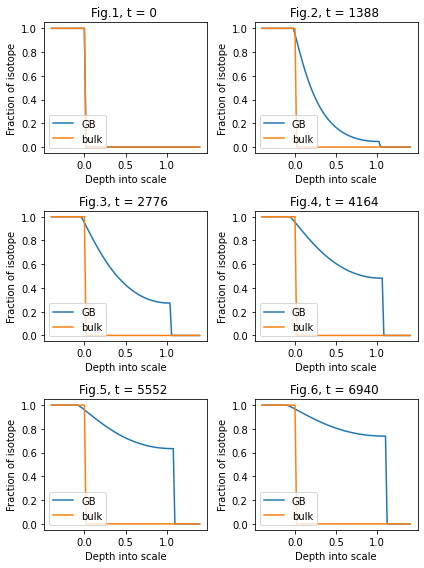


plot_count = 6  figs_on_page = 6  max_figs_per_page = 6

*** LEAVING plot_concentrations ***


* Seems like time to add a scale node from metal *


t_count_2 = 1284
delta_length_2 = 0.019999493981420896 t = 7075 t_count_2 = 1284 


*** ENTERING update_ranges ***

Previous values of ngridy_gas, ngridy_scale, ngridy_metal 15 61 15
One node to be added to scale grid and taken from metal grid
New values of ngridy_gas, ngridy_scale, ngridy_metal =  15 62 14

*** LEAVING update_ranges, scale node added in metal direction *** 


Expected number of timesteps before incrementing scale grid
 based on initial increment only =  1305  Actual number =  1284 

 Number of nodes added to scale : 11

* Seems like time to add a scale node from gas *


t_count_1 = 1284
delta_length_1 = 0.019999238540697687 t = 7075 t_count_1 = 1284 


*** ENTERING update_ranges ***

Previous values of ngridy_gas, ngridy_scale, ngridy_metal 15 62 14
One node to be added to scale grid and taken from gas grid
New values of 


plot_count =  11  figs_on_page =  5  max_figs_per_page =  6


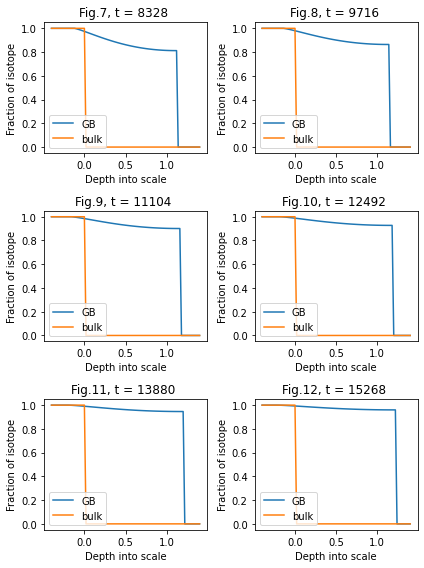


plot_count = 12  figs_on_page = 6  max_figs_per_page = 6

*** LEAVING plot_concentrations ***


* Seems like time to add a scale node from metal *


t_count_2 = 1536
delta_length_2 = 0.01999205255159642 t = 15667 t_count_2 = 1536 


*** ENTERING update_ranges ***

Previous values of ngridy_gas, ngridy_scale, ngridy_metal 9 73 9
One node to be added to scale grid and taken from metal grid
New values of ngridy_gas, ngridy_scale, ngridy_metal =  9 74 8

*** LEAVING update_ranges, scale node added in metal direction *** 


Expected number of timesteps before incrementing scale grid
 based on initial increment only =  1557  Actual number =  1536 

 Number of nodes added to scale : 23

* Seems like time to add a scale node from gas *


t_count_1 = 1536
delta_length_1 = 0.01999187426545417 t = 15667 t_count_1 = 1536 


*** ENTERING update_ranges ***

Previous values of ngridy_gas, ngridy_scale, ngridy_metal 9 74 8
One node to be added to scale grid and taken from gas grid
New values of ngrid

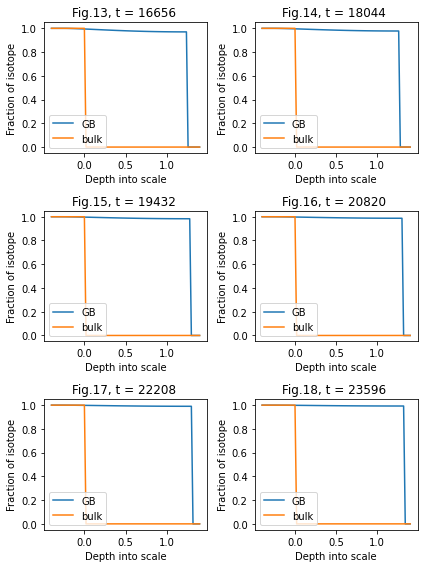


plot_count = 18  figs_on_page = 6  max_figs_per_page = 6

*** LEAVING plot_concentrations ***


* Seems like time to add a scale node from metal *


t_count_2 = 1747
delta_length_2 = 0.019999474433079138 t = 23983 t_count_2 = 1747 


*** ENTERING update_ranges ***

Previous values of ngridy_gas, ngridy_scale, ngridy_metal 4 83 4
One node to be added to scale grid and taken from metal grid
New values of ngridy_gas, ngridy_scale, ngridy_metal =  4 84 3

*** LEAVING update_ranges, scale node added in metal direction *** 


Expected number of timesteps before incrementing scale grid
 based on initial increment only =  1768  Actual number =  1747 

 Number of nodes added to scale : 33

* Seems like time to add a scale node from gas *


t_count_1 = 1747
delta_length_1 = 0.019999336464749738 t = 23983 t_count_1 = 1747 


*** ENTERING update_ranges ***

Previous values of ngridy_gas, ngridy_scale, ngridy_metal 4 84 3
One node to be added to scale grid and taken from gas grid
New values of ngr

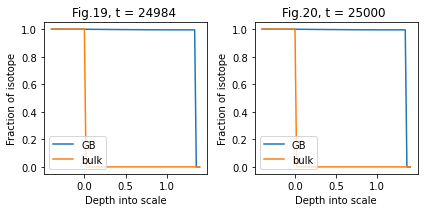


plot_count = 20  figs_on_page = 2  max_figs_per_page = 6

*** LEAVING plot_concentrations ***


*** LEAVING tracer_diffusion ***

c_GB =
 [1.       1.       1.       1.       0.999988 0.999964 0.99993  0.999887
 0.999838 0.999782 0.99972  0.999653 0.999581 0.999505 0.999424 0.999341
 0.999254 0.999164 0.999071 0.998976 0.99888  0.998781 0.998681 0.99858
 0.998477 0.998374 0.99827  0.998165 0.99806  0.997955 0.99785  0.997745
 0.99764  0.997536 0.997432 0.997329 0.997226 0.997124 0.997024 0.996924
 0.996825 0.996728 0.996632 0.996537 0.996443 0.996352 0.996261 0.996173
 0.996086 0.996001 0.995917 0.995836 0.995756 0.995679 0.995603 0.995529
 0.995458 0.995388 0.995321 0.995256 0.995192 0.995132 0.995073 0.995017
 0.994963 0.994911 0.994861 0.994814 0.994769 0.994726 0.994686 0.994648
 0.994613 0.99458  0.994549 0.994521 0.994495 0.994471 0.99445  0.994431
 0.994414 0.9944   0.994389 0.994379 0.994372 0.994367 0.994365 0.994365
 0.       0.       0.      ]


In [18]:
 """
MAIN CODE FOR EXECUTION

"""
#
# The current top-level working directory is defined here
#
os.chdir("/Users/finnis/Documents/Projects/Notes/Scale Growth")
print('Current working directory =', os.getcwd())
working_directory = os.getcwd()
# Create a sub-folder for outputs named by the current date and time:
today = datetime.today()
now = datetime.now()
today = today.strftime('%Y.%m.%d')
now = now.strftime('%H-%M-%S')
output_folder = today + '_' + now
os.mkdir(output_folder)
os.chdir(output_folder)
# Create a file in the output folder for text-only output.
file = open('text_output','a')
#
heading = 'SCALE GROWTH MODEL Version ' + version + "\n"
print(heading)
file.write(heading)
print('\nOutputs will be saved in folder ' + output_folder,'\n')    
new_page = plt.figure()
plot_count, t,  t_count_1, t_count_2,ngridy_gas, ngridy_scale, ngridy_metal, c_GB, c_bulk = \
tracer_diffusion(25000, 1.9,(3,2), bleed=0.0,number_plots=20)
os.chdir(working_directory)

print('c_GB =\n',c_GB)

